In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
cs = pd.read_csv('customer_segmentation.csv')

In [3]:
cs.head()

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio
0,768805383,45,M,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061
1,818770008,49,F,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105
2,713982108,51,M,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000
3,769911858,40,F,4,High School,Unknown,37000,34,3,4,3313.0,1171,20,0.760
4,709106358,40,M,3,Uneducated,Married,65000,21,5,1,4716.0,816,28,0.000


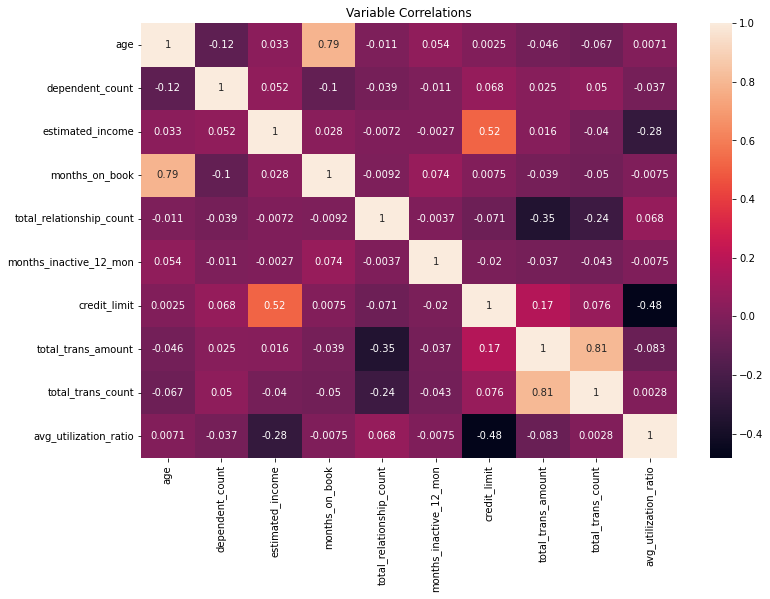

In [4]:
plt.figure(figsize = (12, 8))
cs_numeric = cs.drop(['customer_id', 'gender', 'education_level', 'marital_status'], axis = 1)
sns.heatmap(data = cs_numeric.corr(), annot = True)
plt.title("Variable Correlations")
plt.show()

We can see that the columns with the highest correlations are (age, months_on_book), (estimated_income, credit_limit), (total_trans_amount, total_trans_count), (estimated_income, avg_utilization_ratio), (total_relationship_count, total_trans_amount), (credit_limit, avg_utilization_ratio).

In [5]:
cs.dtypes

customer_id                   int64
age                           int64
gender                       object
dependent_count               int64
education_level              object
marital_status               object
estimated_income              int64
months_on_book                int64
total_relationship_count      int64
months_inactive_12_mon        int64
credit_limit                float64
total_trans_amount            int64
total_trans_count             int64
avg_utilization_ratio       float64
dtype: object

In [6]:
cs.isnull().sum()

customer_id                 0
age                         0
gender                      0
dependent_count             0
education_level             0
marital_status              0
estimated_income            0
months_on_book              0
total_relationship_count    0
months_inactive_12_mon      0
credit_limit                0
total_trans_amount          0
total_trans_count           0
avg_utilization_ratio       0
dtype: int64

In [7]:
cs.drop('customer_id', axis = 1, inplace = True)

We will drop the 'customer_id' column because it won't give us any useful information for our model since it is purely used to identify customers.

In [8]:
cs.shape

(10127, 13)

C:\Users\green\AppData\Local\Temp\ipykernel_35380\144117264.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  cs.hist(ax=ax)


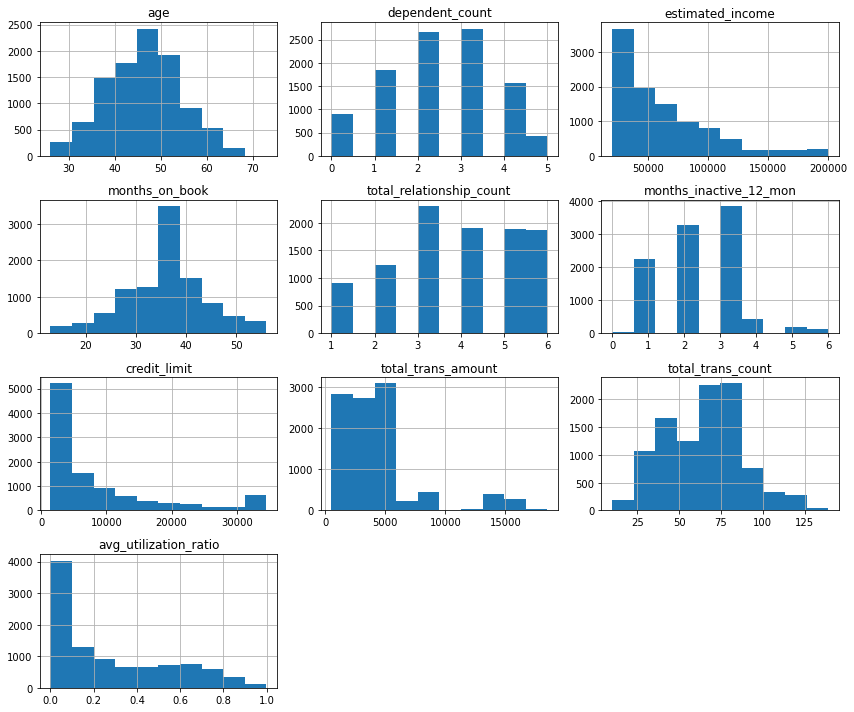

In [10]:
fig, ax = plt.subplots(figsize=(12, 10))

#Removing the customer's id before plotting the distributions
cs.hist(ax=ax)

plt.tight_layout()
plt.show()

In [11]:
customers_modif = cs.copy()

In [12]:
customers_modif['gender'] = customers_modif['gender'].apply(lambda x: 1 if x == 'M' else 0)
customers_modif['gender'].value_counts()

0    5358
1    4769
Name: gender, dtype: int64

We will one-hot encode the gender column so the data can be used for our model.

In [13]:
ed_dict = {'Uneducated': 0, 'High School': 1, 'College': 2, 'Graduate': 3, 'Post-Graduate': 4, 'Doctorate': 5}
customers_modif['education_level'].replace(ed_dict, inplace = True)
customers_modif['education_level'].value_counts()

3    3685
1    2351
0    1755
2    1192
4     616
5     528
Name: education_level, dtype: int64

Since we can rank 'eduction_level', we will assign each level a number in order of increasing experience, and keep our data in one column. 

In [14]:
marital_dummies = pd.get_dummies(customers_modif['marital_status'])
marital_dummies.head()

,Divorced,Married,Single,Unknown
0,0,1,0,0
1,0,0,1,0
2,0,1,0,0
3,0,0,0,1
4,0,1,0,0


Now we've one-hot encoded the 'marital_status' column.

In [15]:
customers_modif = pd.concat([marital_dummies, customers_modif], axis = 1)

In [16]:
customers_modif.drop('marital_status', inplace = True, axis = 1)
customers_modif.head()

,Divorced,Married,Single,Unknown,age,gender,dependent_count,education_level,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio
0,0,1,0,0,45,1,3,1,69000,39,5,1,12691.0,1144,42,0.061
1,0,0,1,0,49,0,5,3,24000,44,6,1,8256.0,1291,33,0.105
2,0,1,0,0,51,1,3,3,93000,36,4,1,3418.0,1887,20,0.000
3,0,0,0,1,40,0,4,1,37000,34,3,4,3313.0,1171,20,0.760
4,0,1,0,0,40,1,3,0,65000,21,5,1,4716.0,816,28,0.000


In [17]:
scaler = StandardScaler()
sc = scaler.fit_transform(customers_modif)
sc = pd.DataFrame(sc)
sc.columns = customers_modif.columns
sc.head()

,Divorced,Married,Single,Unknown,age,gender,dependent_count,education_level,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio
0,-0.282405,1.077338,-0.798507,-0.282609,-0.165406,1.059956,0.503368,-0.752211,0.175810,0.384621,0.763943,-1.327136,0.446622,-0.959707,-0.973895,-0.775882
1,-0.282405,-0.928214,1.252337,-0.282609,0.333570,-0.943436,2.043199,0.662787,-0.967166,1.010715,1.407306,-1.327136,-0.041367,-0.916433,-1.357340,-0.616276
2,-0.282405,1.077338,-0.798507,-0.282609,0.583058,1.059956,0.503368,0.662787,0.785397,0.008965,0.120579,-1.327136,-0.573698,-0.740982,-1.911206,-0.997155
3,-0.282405,-0.928214,-0.798507,3.538459,-0.789126,-0.943436,1.273283,-0.752211,-0.636973,-0.241473,-0.522785,1.641478,-0.585251,-0.951758,-1.911206,1.759686
4,-0.282405,1.077338,-0.798507,-0.282609,-0.789126,1.059956,0.503368,-1.459710,0.074212,-1.869317,0.763943,-1.327136,-0.430877,-1.056263,-1.570365,-0.997155


We scaled our columns so that we are not overweighting or underweighting any datapoints.

[]

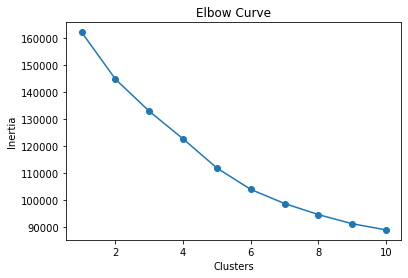

In [18]:
inertia = []
for i in range(1, 11):
    model = KMeans(n_clusters = i)
    model.fit_predict(sc)
    inertia.append(model.inertia_)

plt.plot([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], inertia, marker = 'o')
plt.title('Elbow Curve')
plt.ylabel('Inertia')
plt.xlabel('Clusters')
plt.plot()

We can see above that the 'elbow' is 6.

In [19]:
e_model = KMeans(n_clusters = 6)
clusters = e_model.fit_predict(sc)

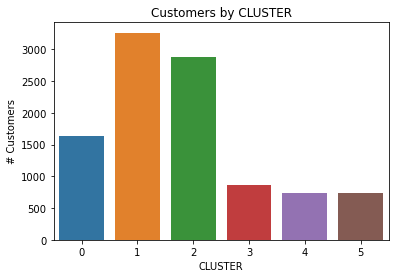

In [20]:
cs['CLUSTER'] = clusters

sns.countplot(data = cs, x = 'CLUSTER')
plt.title('Customers by CLUSTER')
plt.xlabel('CLUSTER')
plt.ylabel('# Customers')
plt.show()

Above, we can see that our clusters vary greatly in size.

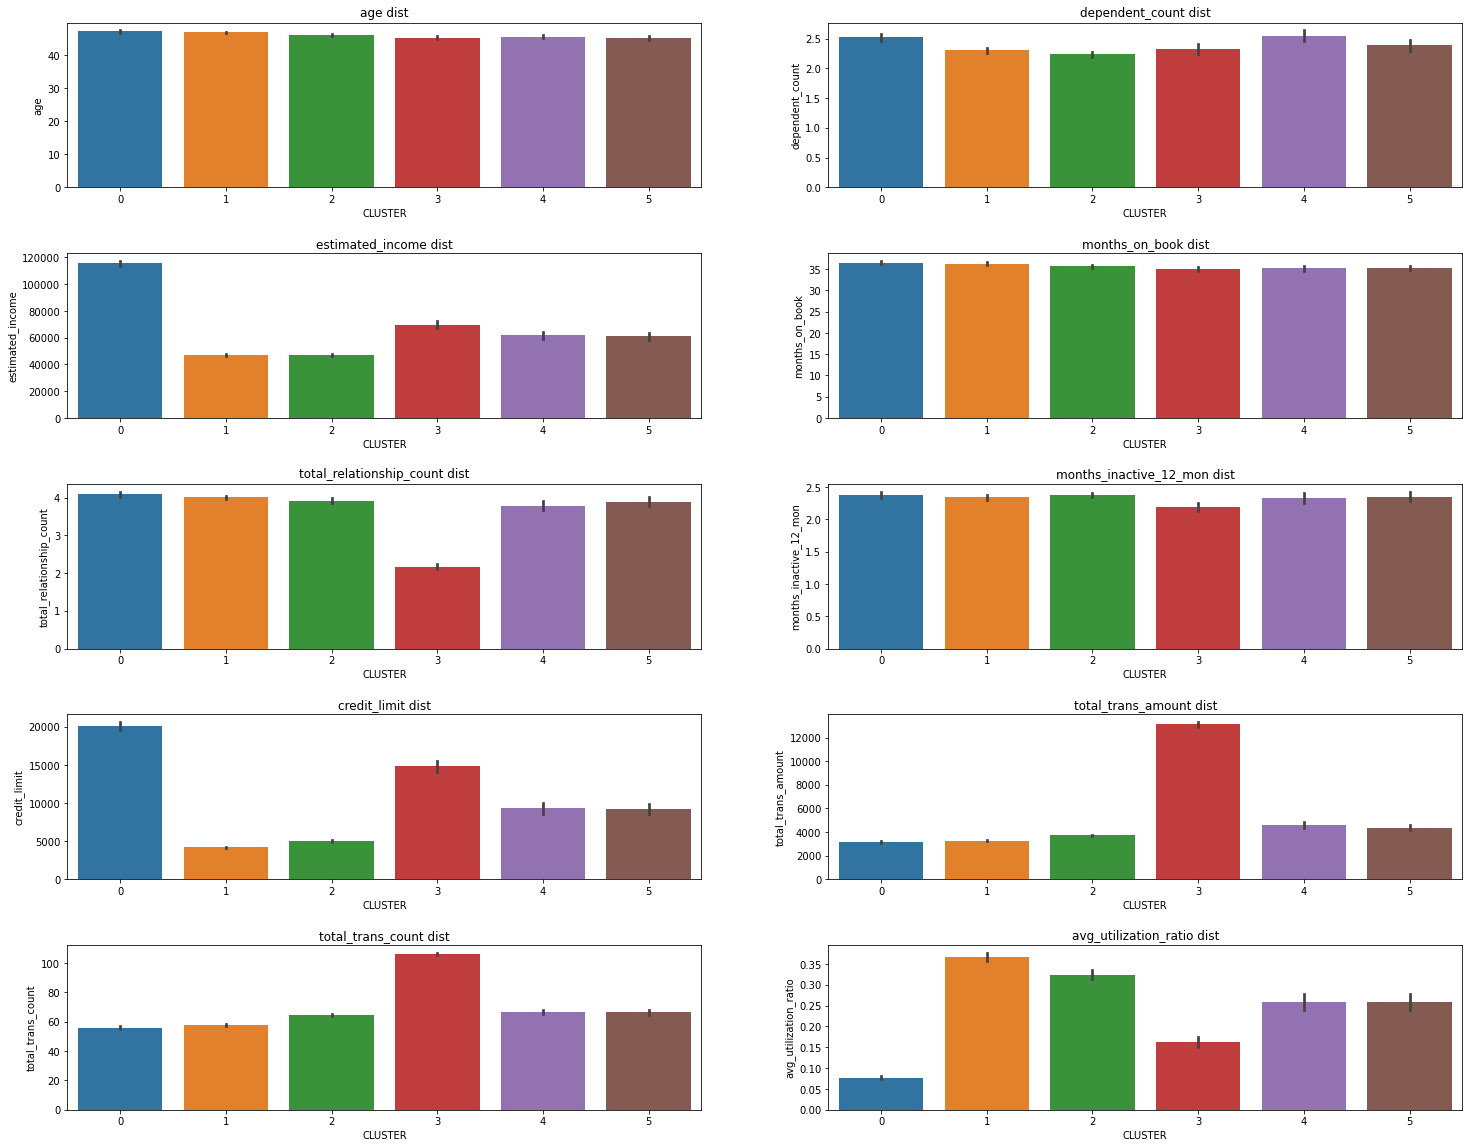

In [24]:
fig, axs = plt.subplots(5, 2, figsize = (25, 20))
sns.barplot(data = cs, x = 'CLUSTER', y = 'age', ax = axs[0, 0])
axs[0,0].set_title('age dist')
sns.barplot(data = cs, x = 'CLUSTER', y = 'dependent_count', ax = axs[0, 1])
axs[0,1].set_title('dependent_count dist')
sns.barplot(data = cs, x = 'CLUSTER', y = 'estimated_income', ax = axs[1, 0], )
axs[1,0].set_title('estimated_income dist')
sns.barplot(data = cs, x = 'CLUSTER', y = 'months_on_book', ax = axs[1, 1])
axs[1,1].set_title('months_on_book dist')
sns.barplot(data = cs, x = 'CLUSTER', y = 'total_relationship_count', ax = axs[2, 0])
axs[2,0].set_title('total_relationship_count dist')
sns.barplot(data = cs, x = 'CLUSTER', y = 'months_inactive_12_mon', ax = axs[2, 1])
axs[2,1].set_title('months_inactive_12_mon dist')
sns.barplot(data = cs, x = 'CLUSTER', y = 'credit_limit', ax = axs[3, 0])
axs[3,0].set_title('credit_limit dist')
sns.barplot(data = cs, x = 'CLUSTER', y = 'total_trans_amount', ax = axs[3, 1])
axs[3,1].set_title('total_trans_amount dist')
sns.barplot(data = cs, x = 'CLUSTER', y = 'total_trans_count', ax = axs[4, 0])
axs[4,0].set_title('total_trans_count dist')
sns.barplot(data = cs, x = 'CLUSTER', y = 'avg_utilization_ratio', ax = axs[4, 1])
axs[4,1].set_title('avg_utilization_ratio dist')
fig.subplots_adjust(hspace=.4)
plt.show()

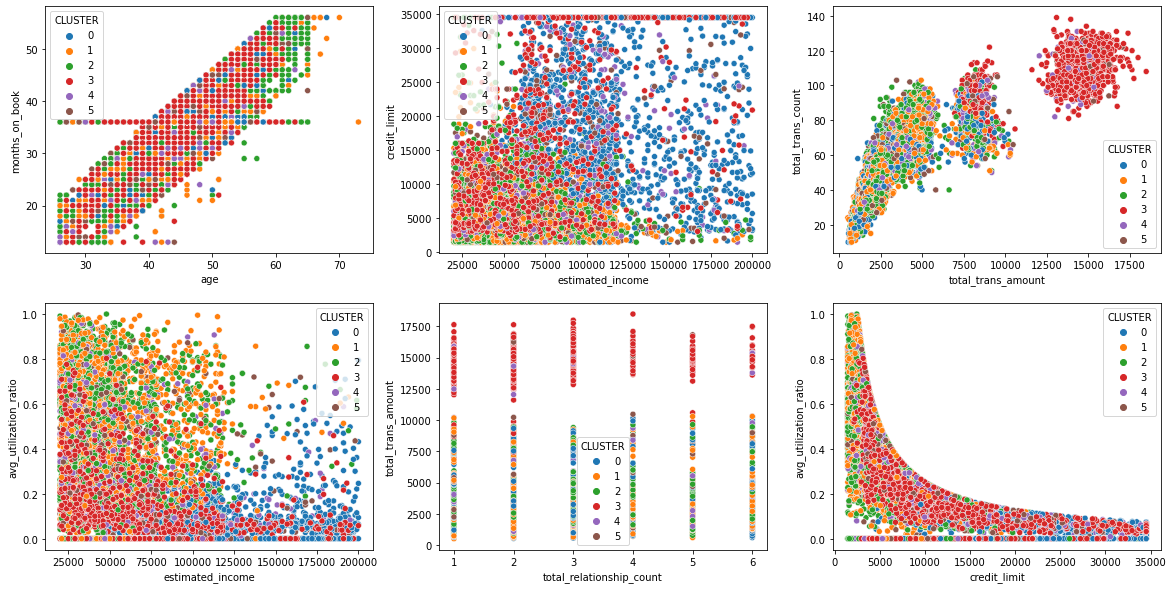

In [25]:
fig, axs = plt.subplots(2, 3, figsize = (20, 10))

sns.scatterplot(data = cs, x = 'age', y = 'months_on_book', hue = 'CLUSTER', palette = 'tab10', ax = axs[0, 0])
sns.scatterplot(data = cs, x = 'estimated_income', y = 'credit_limit', hue = 'CLUSTER', palette = 'tab10', ax = axs[0, 1])
sns.scatterplot(data = cs, x = 'total_trans_amount', y = 'total_trans_count', hue = 'CLUSTER', palette = 'tab10', ax = axs[0, 2])
sns.scatterplot(data = cs, x = 'estimated_income', y = 'avg_utilization_ratio', hue = 'CLUSTER', palette = 'tab10', ax = axs[1, 0])
sns.scatterplot(data = cs, x = 'total_relationship_count', y = 'total_trans_amount', hue = 'CLUSTER', palette = 'tab10', ax = axs[1, 1])
sns.scatterplot(data = cs, x = 'credit_limit', y = 'avg_utilization_ratio', hue = 'CLUSTER', palette = 'tab10', ax = axs[1, 2])
plt.show()

#(estimated_income, avg_utilization_ratio), (total_relationship_count, total_trans_amount), (credit_limit, avg_utilization_ratio)

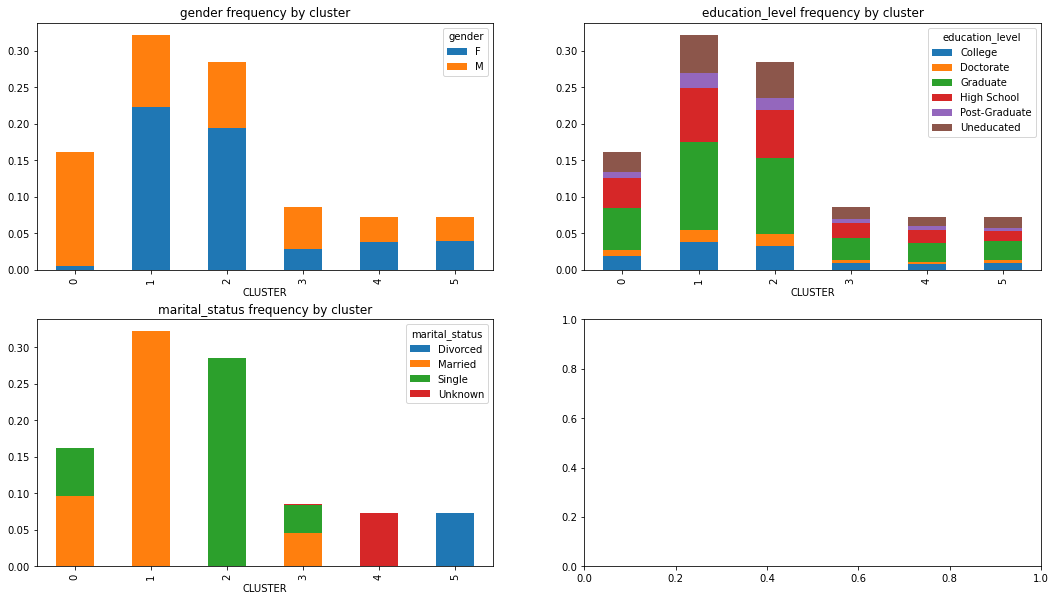

In [38]:
# 'gender', 'education_level', 'marital_status'

fig, axs = plt.subplots(2, 2, figsize = (18, 10))
pd.crosstab(index = cs['CLUSTER'], columns = cs['gender'], normalize = True).plot.bar(stacked = True, ax = axs[0,0])
axs[0,0].set_title('gender frequency by cluster')
pd.crosstab(index = cs['CLUSTER'], columns = cs['education_level'], normalize = True).plot.bar(stacked = True, ax = axs[0,1])
axs[0,1].set_title('education_level frequency by cluster')
pd.crosstab(index = cs['CLUSTER'], columns = cs['marital_status'], normalize = True).plot.bar(stacked = True, ax = axs[1,0])
axs[1,0].set_title('marital_status frequency by cluster')
plt.show()

Cluster 0: This cluster has high income, a high credit limit, a low avg_utilizatio_ratio, is mostly men.
Insight: This cluster could be incentivised to use their card more, as they have lots of money but are choosing to spend it without the use of a credit card. 

Cluster 1: This cluster has low income, a low credit limit, a low amount of transactions, a high avg_utilization_ratio, is mostly women, and everyone is married.
Insight: This group doesn't make many transactions, but they need to use their credit card when they do because of their low income. It may benefit the credit card company to provide financial wellness resources to these customers to increase the odds of these customers paying them back on time.

Cluster 2: This cluster has low income, a low credit limit, a low amount of transactions, a high avg_utilization_ratio, is mostly women, and they are all single.
Insight: These are mostly single women with low income and a high avg_utilization_ratio, and recommendations would be similar to that of Cluster 1.

Cluster 3: This cluster has moderate income, contacts the company very little, has a high credit limit, makes lots of large transactions, and uses their card relativly little.
Insights: This cluster likely has good credit and is probably only using their card for purchases that they cannot make in cash.

Cluster 4: This cluster has moderate income, a low credit limit, spends little on purchases, and only has unknown marital status.
Insight: These people have low credit limits but have high balances, which is a bit odd

Cluster 5: This cluster has moderate income, a low credit limit, spends little on their transactions, uses their card fairly often, and is only divorced.
Insight: Divorced people have low credit limits, but have moderate balances.